<a href="https://colab.research.google.com/github/BlackCurrantDS/ATiML-Project/blob/master/LDA_wihtoutname_and_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install pyLDAvis

In [0]:
!unzip mallet-2.0.8.zip -d mallet

In [0]:
import nltk; nltk.download('stopwords')
import pandas as pd
import numpy as np
import re
import spacy
import en_core_web_sm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [58]:
# Import Dataset
books = pd.read_csv("cleaned_books_WithoutNames.csv")
print(books.genre.unique())
books.head()

['Sea and Adventure' 'Western Stories' 'Love and Romance'
 'Ghost and Horror' 'Humorous and Wit and Satire' 'Literary'
 'Detective and Mystery' 'Christmas Stories']


,Unnamed: 0,id,genre,data
0,0,0,Sea and Adventure,dedicated brother melville ago published narra...
1,1,1,Sea and Adventure,voyaging straight maramma lived reigned myster...
2,2,2,Sea and Adventure,slender girl tan coat white tamoshanter fronti...
3,3,3,Sea and Adventure,heart hill land glenavelin stretch west south ...
4,4,4,Sea and Adventure,yarn day clipper sailingship zenith renown rec...


In [0]:
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('wordnet')

In [0]:
#last 5
#books['data'] = books['data'].apply(lambda x: str(x)[-100:])
#first 5
books['data'] = books['data'].apply(lambda x: str(x)[:50])
# random 2/3
#books['NData'] = books['NData'].apply(lambda x: x[3000:int(len(x)*1/3)])


In [0]:
# Convert to list
data = books.data.values.tolist()
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#print(data[:1])

In [0]:
"""
from nltk.tokenize import RegexpTokenizer
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(data)):
    data[idx] = data[idx].lower()  # Convert to lowercase.
    data[idx] = tokenizer.tokenize(data[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
data = [[token for token in doc if not token.isnumeric()] for doc in data]

# Remove words that are only one character.
data = [[token for token in doc if len(token) > 1] for doc in data]

"""

In [0]:
"""
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
data = [[lemmatizer.lemmatize(token) for token in doc] for doc in data]
"""

In [0]:
"""
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(data, min_count=20)
for idx in range(len(data)):
    for token in bigram[data[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data[idx].append(token)
"""

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
"""
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(data)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
"""

In [0]:
"""
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in data]
"""

In [0]:
"""
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
"""

Number of unique tokens: 236
Number of documents: 40


In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])

In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['VERB', 'NOUN', 'NP', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['VERB', 'ADJ'])

#print(data_lemmatized[:1])

In [0]:
"""
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
"""

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                            alpha='auto',
                                            eta='auto',
                                           per_word_topics=False)

In [71]:
# Print the Keyword in the 8 topics
print(lda_model.print_topics(8))
doc_lda = lda_model[corpus]

[(0, '0.059*"live" + 0.059*"voyage" + 0.059*"reigned" + 0.059*"straight" + 0.059*"solitary" + 0.059*"moisten" + 0.059*"immaculate" + 0.059*"select" + 0.059*"revise" + 0.059*"arrive"'), (1, '0.075*"combine" + 0.075*"bracken" + 0.075*"dream" + 0.075*"idealist" + 0.075*"mix" + 0.075*"vast" + 0.044*"gorgeous" + 0.010*"poor" + 0.010*"fashionable" + 0.009*"idle"'), (2, '0.055*"carry" + 0.055*"enjoy" + 0.055*"spend" + 0.055*"walk" + 0.055*"scurry" + 0.055*"think" + 0.055*"decent" + 0.055*"hear" + 0.055*"realise" + 0.055*"frozen"'), (3, '0.086*"stay" + 0.086*"cleanshaven" + 0.086*"proclaim" + 0.054*"poor" + 0.051*"speak" + 0.048*"idle" + 0.011*"fashionable" + 0.011*"gorgeous" + 0.010*"publish" + 0.010*"prepare"'), (4, '0.109*"prepare" + 0.059*"fashionable" + 0.058*"interested" + 0.058*"pretty" + 0.058*"unanimou" + 0.058*"dismay" + 0.058*"philosopher" + 0.058*"rock" + 0.058*"oldfashioned" + 0.058*"rider"'), (5, '0.069*"fashionable" + 0.068*"beg" + 0.068*"acknowl" + 0.068*"answer" + 0.068*"dodgi

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.109246  0.127547       1        1  16.569893
4     -0.139695  0.058740       2        1  15.073492
0      0.021287 -0.088841       3        1  13.969771
5     -0.055403  0.023862       4        1  12.882012
7      0.027862 -0.063090       5        1  12.391992
1      0.009074 -0.016142       6        1   9.921265
3      0.011580 -0.014393       7        1   9.596234
6      0.016050 -0.027683       8        1   9.595345, topic_info=            Term      Freq     Total Category  logprob  loglift
1        publish  1.000000  1.000000  Default  30.0000  30.0000
20       prepare  1.000000  1.000000  Default  29.0000  29.0000
31          stay  1.000000  1.000000  Default  28.0000  28.0000
30   cleanshaven  1.000000  1.000000  Default  27.0000  27.0000
62      proclaim  1.000000  1.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
20       prepare  0.054671  1.592148   Topic8  -4.7966  -1.0276
38          trim  0.053985  1.076769   Topic8  -4.8093  -0.6491
19  oldfashioned  0.053963  1.052318   Topic8  -4.8097  -0.6266
23          rock  0.053937  1.052220   Topic8  -4.8101  -0.6269
16   philosopher  0.053935  1.052188   Topic8  -4.8102  -0.6270

[342 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
55        4  0.946076         acknowl
24        4  0.946061          answer
15        3  0.973435          arrive
25        4  0.946030             ask
26        4  0.946076             beg
48        6  1.026092         bracken
39        1  0.929154           carry
28        5  0.992586         chinese
30        7  0.975434     cleanshaven
60        6  1.026105         combine
45        1  0.929071          decent
0         5  0.992590       dedicated
51        2  0.950532          dismay
27        4  0.946053         dodging
49        6  1.026059           dream
40        1  0.929126           enjoy
52        2  0.605563     fashionable
52        4  0.605563     fashionable
7         1  0.929006          frozen
8         1  0.929056            hear
21        5  0.992571            high
61        6  1.025928        idealist
36        3  0.973949      immaculate
53        2  0.950549      interested
29        5  0.992582        japanese
2         3  0.974167            live
43        6  1.025535             mix
37        3  0.973960         moisten
19        2  0.950283    oldfashioned
16        2  0.950401     philosopher
44        5  0.633481            poor
20        2  0.628082         prepare
17        2  0.950543          pretty
62        7  0.974850        proclaim
1         5  0.665381         publish
46        1  0.929016         realise
3         3  0.974162         reigned
10        1  0.928560          remote
50        3  0.973537          revise
6         2  0.949737           rider
23        2  0.950371            rock
47        1  0.929094          scurry
63        3  0.973778          select
22        5  0.992554           shine
64        3  0.974029        solitary
41        1  0.929109           spend
56        4  0.946037           stand
31        7  0.975486            stay
4         3  0.974161        straight
54        5  0.991881          strike
9         1  0.929083           think
38        1  0.928704            trim
57        4  0.946035  ultraexclusive
18        2  0.950534        unanimou
34        6  1.025485            vast
5         3  0.974166          voyage
42        1  0.929107            walk, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 6, 8, 2, 4, 7])

In [74]:
#Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [48]:
print(ldamallet.show_topics(formatted=False))

[(0, [('publish', 0.05263157894736842), ('carry', 0.05263157894736842), ('remote', 0.05263157894736842), ('obstruct', 0.05263157894736842), ('strong', 0.05263157894736842), ('bes', 0.05263157894736842), ('rock', 0.05263157894736842), ('study', 0.05263157894736842), ('disappear', 0.05263157894736842), ('bring', 0.05263157894736842)]), (1, [('proclaim', 0.0625), ('commonplace', 0.0625), ('decent', 0.0625), ('rise', 0.0625), ('warm', 0.0625), ('bracken', 0.0625), ('remarkable', 0.0625), ('move', 0.0625), ('idle', 0.0625), ('wild', 0.0625)]), (2, [('comfortable', 0.08333333333333333), ('infernal', 0.08333333333333333), ('motive', 0.08333333333333333), ('smile', 0.08333333333333333), ('individual', 0.08333333333333333), ('stay', 0.08333333333333333), ('japanese', 0.08333333333333333), ('philosopher', 0.08333333333333333), ('procrastinate', 0.08333333333333333), ('proper', 0.08333333333333333)]), (3, [('meet', 0.1111111111111111), ('fashionable', 0.1111111111111111), ('dig', 0.05555555555555

In [75]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7433476875353144


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [77]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


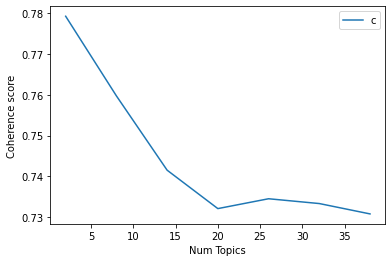

In [78]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7793
Num Topics = 8  has Coherence Value of 0.7597
Num Topics = 14  has Coherence Value of 0.7415
Num Topics = 20  has Coherence Value of 0.7321
Num Topics = 26  has Coherence Value of 0.7345
Num Topics = 32  has Coherence Value of 0.7333
Num Topics = 38  has Coherence Value of 0.7308


In [80]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.200*"bracken" + 0.200*"stay" + 0.200*"revise" + 0.200*"japanese" + 0.200*"strike" + 0.000*"walk" + 0.000*"decent" + 0.000*"poor" + 0.000*"mix" + 0.000*"enjoy"'), (1, '0.250*"oldfashioned" + 0.250*"combine" + 0.250*"frozen" + 0.250*"publish" + 0.000*"mix" + 0.000*"scurry" + 0.000*"realise" + 0.000*"decent" + 0.000*"poor" + 0.000*"bracken"'), (2, '0.250*"answer" + 0.250*"spend" + 0.250*"decent" + 0.250*"unanimou" + 0.000*"poor" + 0.000*"moisten" + 0.000*"scurry" + 0.000*"realise" + 0.000*"immaculate" + 0.000*"trim"'), (3, '0.667*"prepare" + 0.333*"idle" + 0.000*"walk" + 0.000*"realise" + 0.000*"decent" + 0.000*"poor" + 0.000*"mix" + 0.000*"bracken" + 0.000*"spend" + 0.000*"trim"'), (4, '0.250*"remote" + 0.250*"dream" + 0.250*"solitary" + 0.250*"arrive" + 0.000*"scurry" + 0.000*"realise" + 0.000*"decent" + 0.000*"poor" + 0.000*"walk" + 0.000*"mix"'), (5, '1.000*"gorgeous" + 0.000*"walk" + 0.000*"enjoy" + 0.000*"realise" + 0.000*"decent" + 0.000*"poor" + 0.000*"mix" + 0.000*"bracke

In [81]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.0694,"dedicated, live, walk, scurry, realise, decent...",dedicated brother melville ago published narra...
1,1,19.0,0.0751,"hear, moisten, reigned, straight, realise, enj...",voyaging straight maramma lived reigned myster...
2,2,0.0,0.0500,"bracken, stay, revise, japanese, strike, walk,...",slender girl tan coat white tamoshanter fronti...
3,3,0.0,0.0500,"bracken, stay, revise, japanese, strike, walk,...",heart hill land glenavelin stretch west south ...
4,4,0.0,0.0500,"bracken, stay, revise, japanese, strike, walk,...",yarn day clipper sailingship zenith renown rec...
5,5,12.0,0.0664,"philosopher, obstruct, stand, trim, carry, ult...",rider bar hidden trail lynch lawyer owner lazy...
6,6,1.0,0.0652,"oldfashioned, combine, frozen, publish, mix, s...",write hold thought heard frozen north time dis...
7,7,4.0,0.0621,"remote, dream, solitary, arrive, scurry, reali...",remote stream influence pour birth channel ins...
8,8,17.0,0.0609,"select, immaculate, current, mix, enjoy, reali...",neighbor current life silence obstructing rive...
9,9,14.0,0.0652,"walk, understand, shine, voyage, vast, spend, ...",understand motive writing book affectionately ...


In [88]:
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic['Keywords'][0]


'dedicated, live, walk, scurry, realise, decent, poor, mix, bracken, trim'

In [89]:
df_dominant_topic['Text'][0]

'dedicated brother melville ago published narrative'